## Music genre classifier
- normalizovat data 
- feature engineering
- doplnit tokenizovany text do features listu,
- skusit ine klasifikatory(random forest)
- grid search
- hrat sa s jednotlivymi triedami
- dokumentacia
- confusion_matrix pre vysledky


In [182]:
import pandas as pd
import numpy as np

import os
from os import path
from os import getcwd

from matplotlib import pyplot as plt
import seaborn as sb

import sklearn
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import nltk
from nltk.corpus import stopwords

from scipy import stats
from scipy import misc

import io
import pydotplus
import graphviz
import warnings

#nltk.download()
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

### Data processing
- load data
- erase unimportant column
- show genre distribution
- print genres
- balance genre distribution

C:\Users\jakub\Desktop\MichalKodiDodzaleny\..\msd_genre_dataset.txt
['classic pop and rock' 'punk' 'folk' 'pop' 'dance and electronica'
 'metal' 'jazz and blues' 'classical' 'hip-hop' 'soul and reggae']


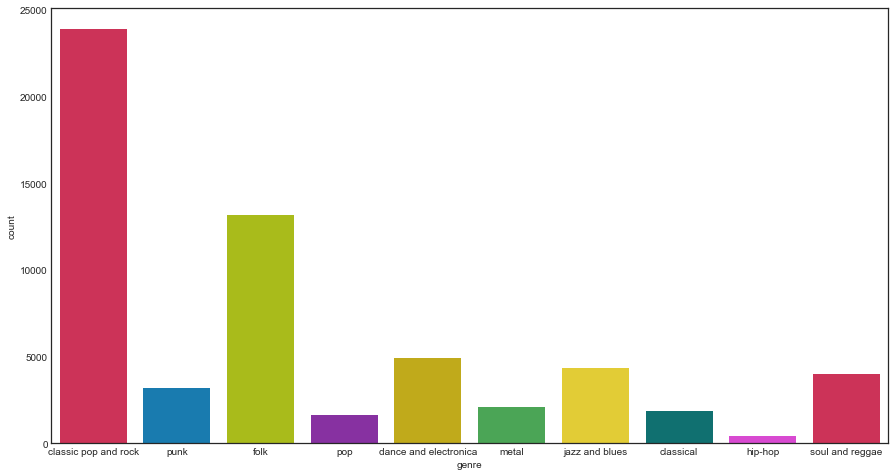

In [197]:
data_filename = path.join(getcwd(), '..', 'msd_genre_dataset.txt')
print(data_filename)
pandas_data = pd.read_csv(data_filename, header=0)
del pandas_data['track_id']
pandas_data.rename(columns={'%genre': 'genre'}, inplace=True)

red_blue = ['#e6194b', '#0082c8','#bdd600','#911eb4', '#dbbe00', '#3cb44b','#ffe119','#008080', '#f032e6']
palette = sb.color_palette(red_blue)
sb.set_palette(palette)
sb.set_style('white')
fig = plt.figure(figsize=(15,8))
sb.countplot(x="genre", data=pandas_data, palette=red_blue)

genre_column = pandas_data['genre']
print(genre_column.unique())

#len(pandas_data[(pandas_data['%genre'] == 'dance and electronica')])

In [225]:
poprock = sklearn.utils.shuffle(pandas_data[pandas_data['genre'] == 'classic pop and rock'])
folk = sklearn.utils.shuffle(pandas_data[pandas_data['genre'] == 'folk'])

poprock = poprock[:int(5000)]
folk = folk[:int(5000)]

pandas_data = pandas_data.drop(pandas_data[pandas_data['genre'] == 'classic pop and rock'].index)
pandas_data = pandas_data.drop(pandas_data[pandas_data['genre'] == 'folk'].index)

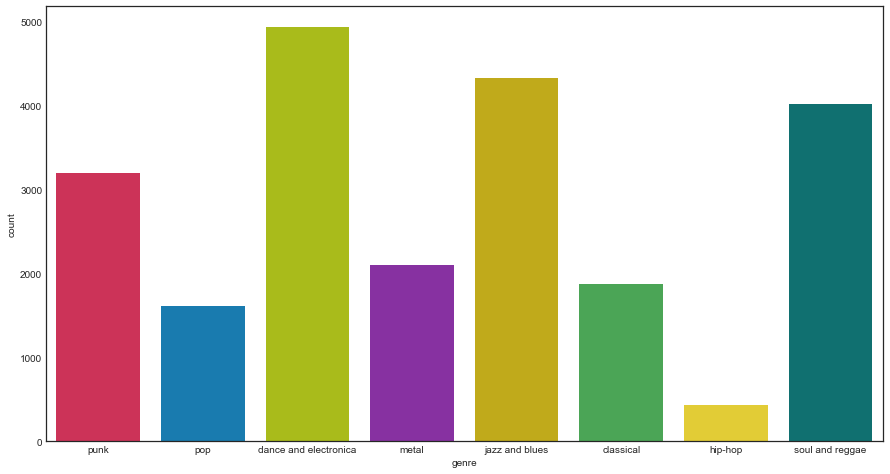

In [226]:
frames = [pandas_data, poprock, folk]
df = pd.concat(frames)

fig = plt.figure(figsize=(15,8))
sb.countplot(x="genre", data=df, palette=red_blue)

### Features adjusment
- tokenize and remove stop words from title
- tokenize and remove stop words from artist name

In [227]:
df['tokenized_title'] = df.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)
df['tokenized_artist_name'] = df.apply(lambda row: nltk.word_tokenize(row['artist_name']), axis=1)
stop_words = stopwords.words('english')

#for i,row in pandas_data.iterrows():
#    print(row.tokenized_title)
#    row.tokenized_title = [word for word in row.tokenized_title if not word.lower() in stop_words and word.isalpha()]
#    print(row.tokenized_title)

def removeStopWors(words):
    out = [word for word in words if not word.lower() in stop_words and word.isalpha()]
    return out

df['tokenized_title'] = df.apply(lambda row: removeStopWors(row['tokenized_title']), axis=1)
df['tokenized_artist_name'] = df.apply(lambda row: removeStopWors(row['tokenized_artist_name']), axis=1)

df

,genre,artist_name,title,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,...,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12,tokenized_title,tokenized_artist_name
23895,punk,Gaz Nevada,I C Love Affair,-11.692,215.680,4,7,1,390.21669,37.407679,...,1438.709380,1409.052050,469.471179,701.122890,205.498069,416.394306,308.376192,205.342829,"[C, Love, Affair]","[Gaz, Nevada]"
23896,punk,Close Combat,Pieke,-8.465,181.727,4,2,1,222.01424,47.481769,...,744.527096,576.282914,312.065861,341.816107,438.786829,217.185562,172.488676,107.900188,[Pieke],"[Close, Combat]"
23897,punk,Close Combat,One Goal,-9.802,143.258,1,7,1,234.97098,45.215285,...,875.340084,479.630136,367.788692,315.335050,383.704213,198.750683,147.167370,132.249188,"[One, Goal]","[Close, Combat]"
23898,punk,Close Combat,Skinhead Pride,-10.002,198.678,4,9,1,171.12771,45.416330,...,693.201666,643.482582,323.476615,284.213170,266.876326,173.105332,199.876823,142.242248,"[Skinhead, Pride]","[Close, Combat]"
23899,punk,Close Combat,Guest Of The State,-9.782,197.259,4,7,1,168.80281,45.392111,...,781.728128,582.849445,374.209090,263.218574,396.554976,211.750683,196.885589,177.964331,"[Guest, State]","[Close, Combat]"
23900,punk,Close Combat,I Just Wanna Get Drunk,-9.001,99.516,4,7,1,141.84444,45.980448,...,1104.530120,396.024525,404.831204,380.504331,435.906053,200.452407,102.594547,179.817923,"[Wan, na, Get, Drunk]","[Close, Combat]"
23901,punk,Close Combat,When We Were Young,-9.845,103.535,1,0,1,229.95546,46.363056,...,878.878205,422.782637,260.954550,323.685765,227.633381,170.370843,138.298570,155.811867,[Young],"[Close, Combat]"
23902,punk,Close Combat,On Parole,-10.516,106.755,4,7,1,197.64200,45.386020,...,842.941833,502.959382,226.504481,240.647197,306.873210,155.070619,155.273895,97.041183,[Parole],"[Close, Combat]"
23903,punk,Close Combat,M.V.V.,-8.355,90.911,4,0,1,158.66730,47.046759,...,644.978936,863.213108,338.775577,346.809578,424.969079,251.385997,296.520915,137.544830,[],"[Close, Combat]"
23904,punk,Close Combat,Gebore En Getoge,-9.401,181.812,4,7,1,187.74159,47.602056,...,411.392892,301.648640,213.229400,236.726622,446.394200,180.907584,139.388226,218.101898,"[Gebore, En, Getoge]","[Close, Combat]"


In [228]:
df.describe()

,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,avg_timbre2,avg_timbre3,avg_timbre4,...,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
count,22513.000000,22513.000000,22513.000000,22513.000000,22513.000000,22513.000000,22513.000000,22513.000000,22513.000000,22513.000000,...,22513.000000,22513.000000,22513.000000,22513.000000,22513.000000,22513.000000,22513.000000,22513.000000,22513.000000,22513.000000
mean,-11.414146,123.477560,3.562431,5.297828,0.629547,275.930970,41.177428,-4.238811,5.112050,3.037240,...,2338.107533,1706.747018,987.159484,964.869176,670.854580,542.830301,424.577761,334.755646,309.107179,324.745946
std,6.645266,37.719609,1.299132,3.613502,0.482937,159.448034,7.756462,61.082085,40.731927,18.450273,...,1513.744125,1216.427936,532.651733,649.613780,364.663484,334.907975,245.589266,179.141208,204.827321,188.347415
min,-48.057000,0.000000,0.000000,0.000000,0.000000,1.201180,8.282830,-318.656281,-257.525596,-120.723153,...,95.505318,110.570448,50.263681,37.403374,60.896276,36.801235,33.611425,21.861296,20.006805,21.180689
25%,-14.415000,96.070000,3.000000,2.000000,0.000000,189.282810,36.959947,-36.027203,-18.502337,-7.894279,...,1292.933850,914.834326,636.424768,503.169082,420.435748,317.408056,265.942555,207.199872,171.626536,206.204320
50%,-9.630000,120.999000,4.000000,5.000000,1.000000,243.408530,42.640536,6.457623,6.904128,0.917310,...,2071.443993,1426.608591,890.548709,816.784338,612.686980,465.235268,371.776655,300.235557,259.429022,289.692110
75%,-6.539000,145.829000,4.000000,9.000000,1.000000,326.451790,46.927563,37.794391,28.879759,11.717830,...,3002.624195,2143.826681,1211.234785,1247.802337,841.852316,674.763564,515.811465,422.306855,387.829719,391.026317
max,2.865000,253.036000,7.000000,11.000000,1.000000,2873.808530,58.011152,448.373214,292.952706,130.195510,...,20131.148234,17007.134106,16049.083490,8278.809040,5582.160728,4057.268420,3928.650500,2352.679280,4780.290858,2629.604610


In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22513 entries, 23895 to 59599
Data columns (total 35 columns):
genre                    22513 non-null object
artist_name              22513 non-null object
title                    22513 non-null object
loudness                 22513 non-null float64
tempo                    22513 non-null float64
time_signature           22513 non-null int64
key                      22513 non-null int64
mode                     22513 non-null int64
duration                 22513 non-null float64
avg_timbre1              22513 non-null float64
avg_timbre2              22513 non-null float64
avg_timbre3              22513 non-null float64
avg_timbre4              22513 non-null float64
avg_timbre5              22513 non-null float64
avg_timbre6              22513 non-null float64
avg_timbre7              22513 non-null float64
avg_timbre8              22513 non-null float64
avg_timbre9              22513 non-null float64
avg_timbre10             22513 n

### Data Visualisation
- visualise data by histogram and boxplot
- remove outliers, implemented two methods: IQR and Zscore, for more info: http://colingorrie.github.io/outlier-detection.html

Note: IQR redukovala dataset takmer na polovicu, preto som zvolil Z score ktore redukuje data set menej radikalne z 1800 na 1400 pre classical 

In [212]:
classical = df[df['genre'] == 'classical']
dance = df[df['genre'] == 'dance and electronica']
folk = df[df['genre'] == 'folk']
hiphop = df[df['genre'] == 'hip-hop']
jazz = df[df['genre'] == 'jazz and blues']
metal = df[df['genre'] == 'metal']
pop = df[df['genre'] == 'pop']
poprock = df[df['genre'] == 'classic pop and rock']
punk = df[df['genre'] == 'punk']
reggae = df[df['genre'] == 'soul and reggae']

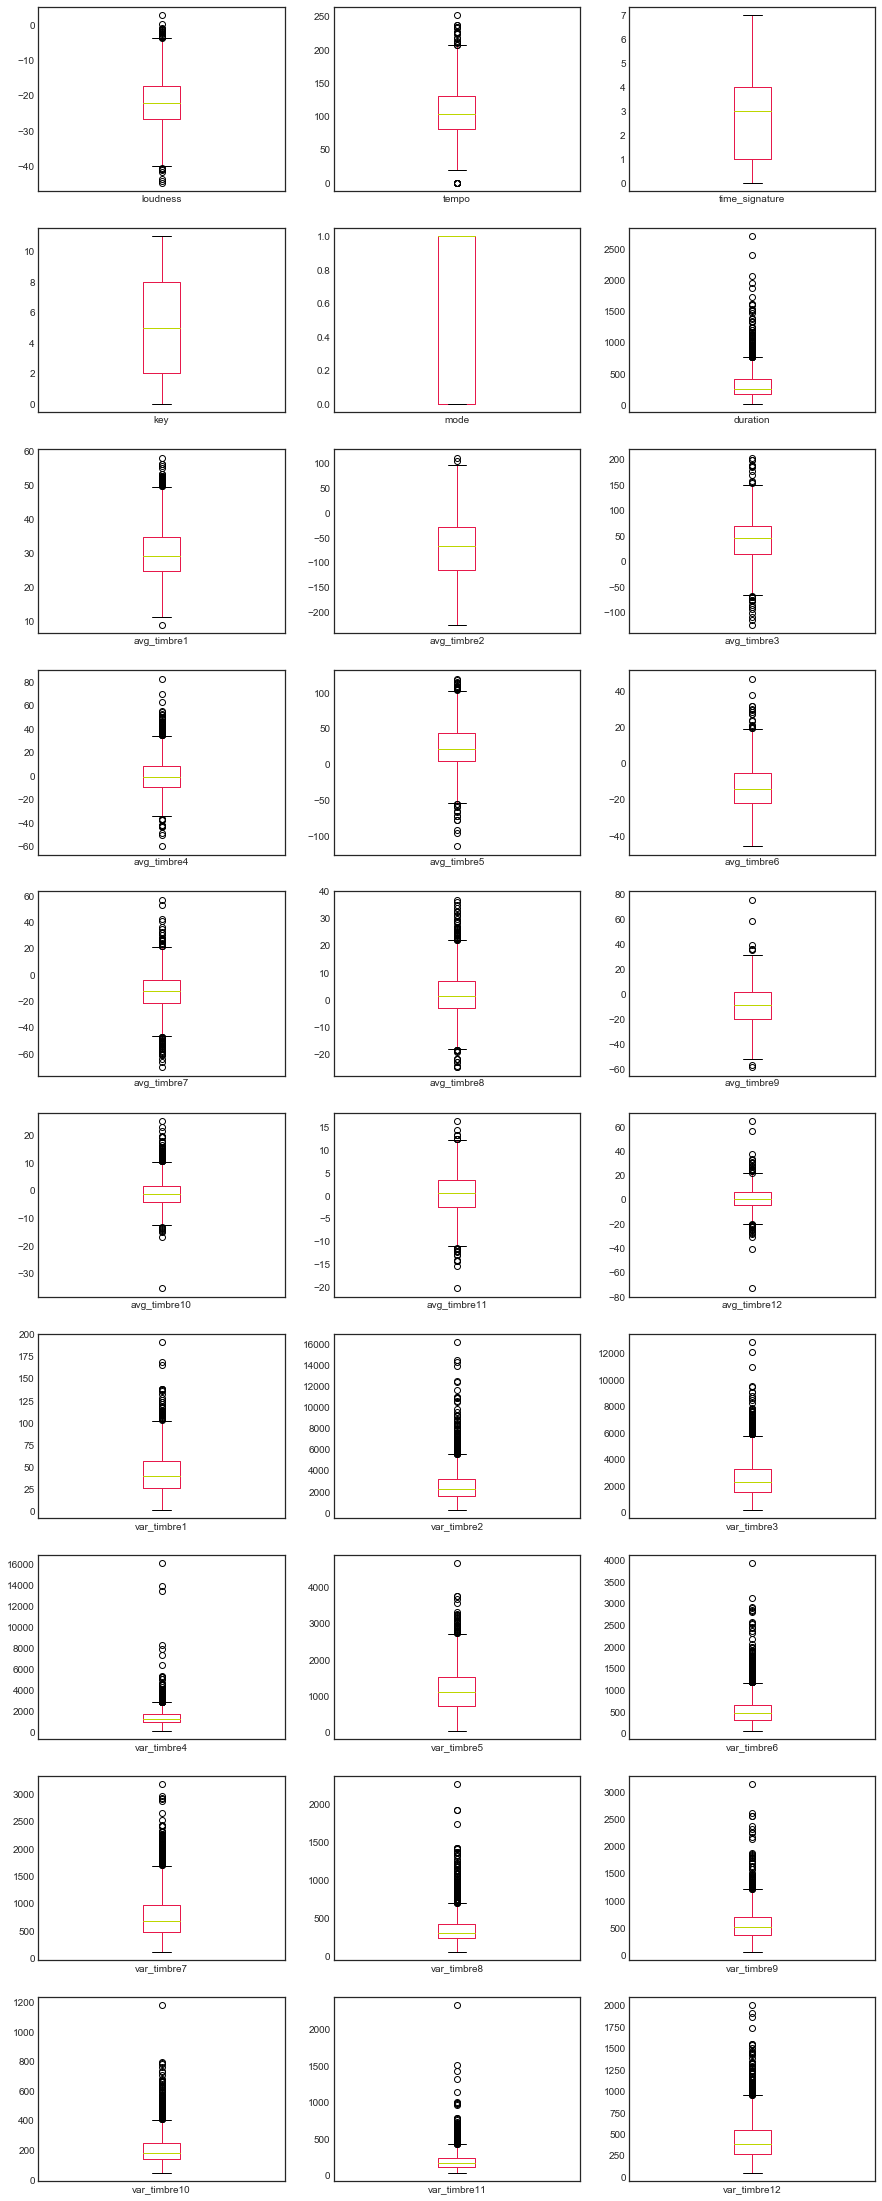

In [231]:
classical.plot(kind='box', subplots=True, layout=(10,3), sharex=False, sharey=False, figsize=(15, 40))
plt.show()

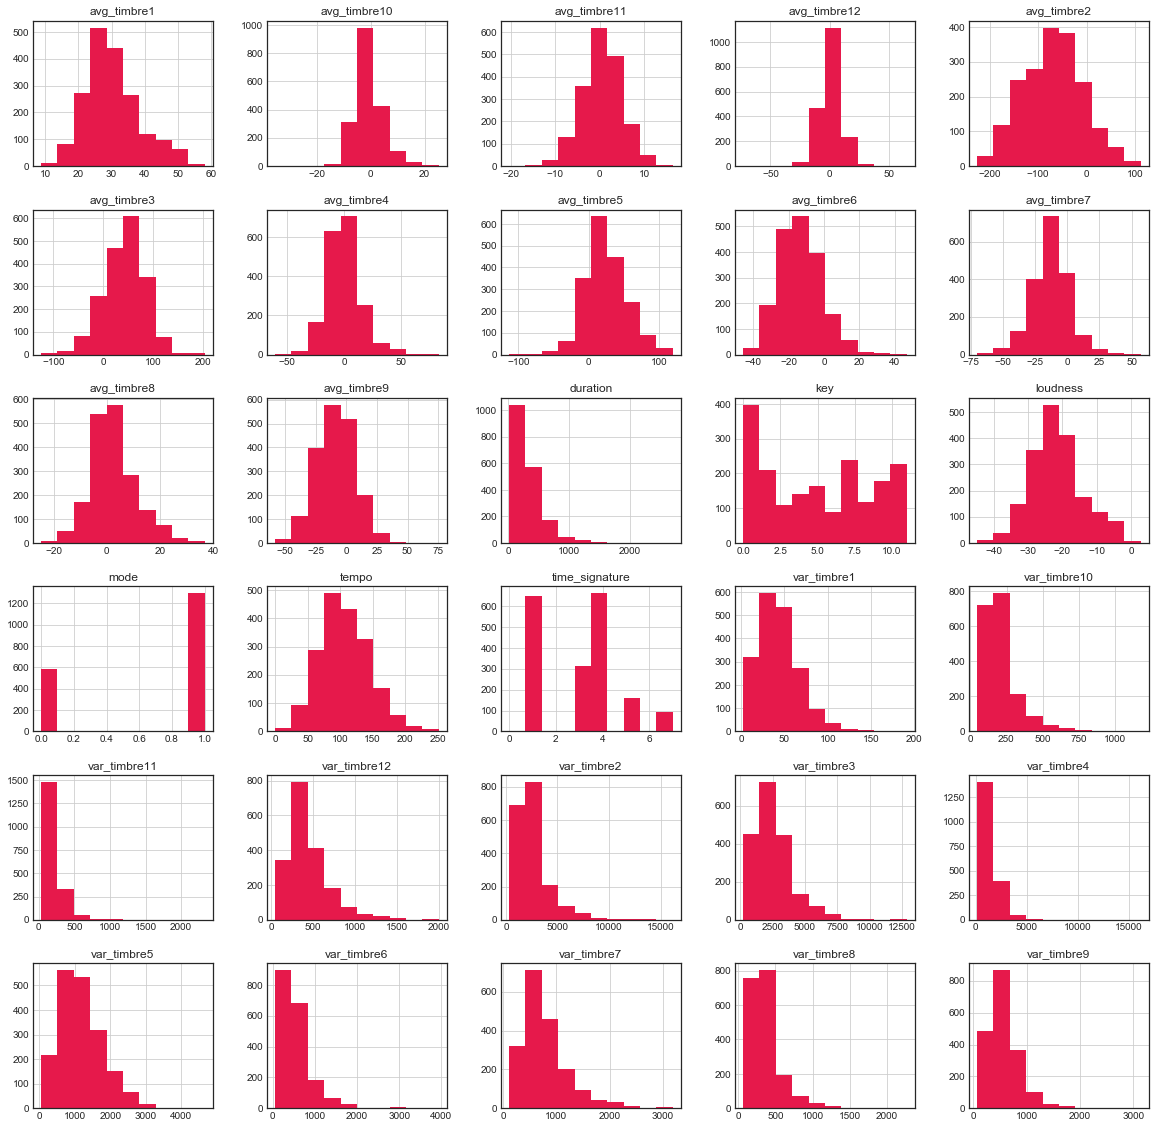

In [205]:
classical.hist()
plt.show()

In [238]:
numerical = ['loudness', 'tempo', 'time_signature', 'key', 'mode', 'duration', 'avg_timbre1',
           'avg_timbre1','avg_timbre2','avg_timbre3','avg_timbre4','avg_timbre5','avg_timbre6',
           'avg_timbre9','avg_timbre8','avg_timbre9','avg_timbre10','avg_timbre11','avg_timbre12',
           'var_timbre1','var_timbre2','var_timbre3','var_timbre4','var_timbre5','var_timbre6',
           'var_timbre7','var_timbre8','var_timbre9','var_timbre10','var_timbre11','var_timbre12']

#------------------------------------------------------------------------------
# accept a dataframe, remove outliers, return cleaned data in a new dataframe
# see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
# IQR method
#------------------------------------------------------------------------------
def iqr_remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-3*iqr
    fence_high = q3+3*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#for col in numerical:
#    classical = iqr_remove_outlier(classical, col)

#------------------------------------------------------------------------------
# accept a dataframe, remove outliers, return cleaned data in a new dataframe
# see http://colingorrie.github.io/outlier-detection.html
# Zscore method
#------------------------------------------------------------------------------
for col in numerical:
     classical = classical[((classical[col] - classical[col].mean()) / classical[col].std()).abs() < 3]

In [241]:
classical.describe()

,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,avg_timbre2,avg_timbre3,avg_timbre4,...,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
count,1425.000000,1425.000000,1425.000000,1425.000000,1425.00000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,...,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000
mean,-22.068126,107.140618,2.948772,4.997895,0.70807,317.757250,29.963783,-79.817911,43.499058,-1.933655,...,2264.181925,1250.270685,1133.147225,467.307865,699.412996,313.163458,535.676084,176.891121,165.780954,404.516706
std,6.912614,36.073713,1.712327,3.446317,0.45481,202.759632,7.493691,59.395792,36.113536,12.801863,...,1143.557636,487.421345,559.276041,235.048386,315.585625,116.539577,234.748329,65.845859,73.999479,182.878653
min,-43.589000,0.000000,1.000000,0.000000,0.00000,22.778320,11.131270,-223.484030,-76.567298,-43.260061,...,208.884921,177.158944,203.447786,61.042334,116.668745,64.284856,68.930987,46.767120,33.175795,73.610049
25%,-26.584000,80.970000,1.000000,2.000000,0.00000,173.191380,24.976521,-125.577657,19.559893,-10.529749,...,1386.561758,903.693687,699.950903,300.119895,463.903547,228.742881,369.072109,132.125252,112.471709,267.989466
50%,-22.336000,103.990000,3.000000,5.000000,1.00000,266.997100,29.045977,-76.521494,45.771203,-2.070785,...,2119.336182,1212.544772,1041.744171,430.869809,639.051695,290.745956,517.428166,165.056754,151.494976,368.462034
75%,-17.912000,131.036000,4.000000,8.000000,1.00000,412.734240,33.936233,-40.915398,68.523170,5.985448,...,2926.820992,1542.031103,1478.046260,596.190549,872.914646,371.555629,673.606286,212.804946,208.058014,513.387358
max,-1.877000,218.034000,7.000000,11.000000,1.00000,1064.332610,53.274847,83.824375,153.201619,40.415607,...,6729.732104,3368.567984,2950.271319,1374.732869,1928.647518,806.451088,1380.494243,419.867839,423.305820,1014.311169


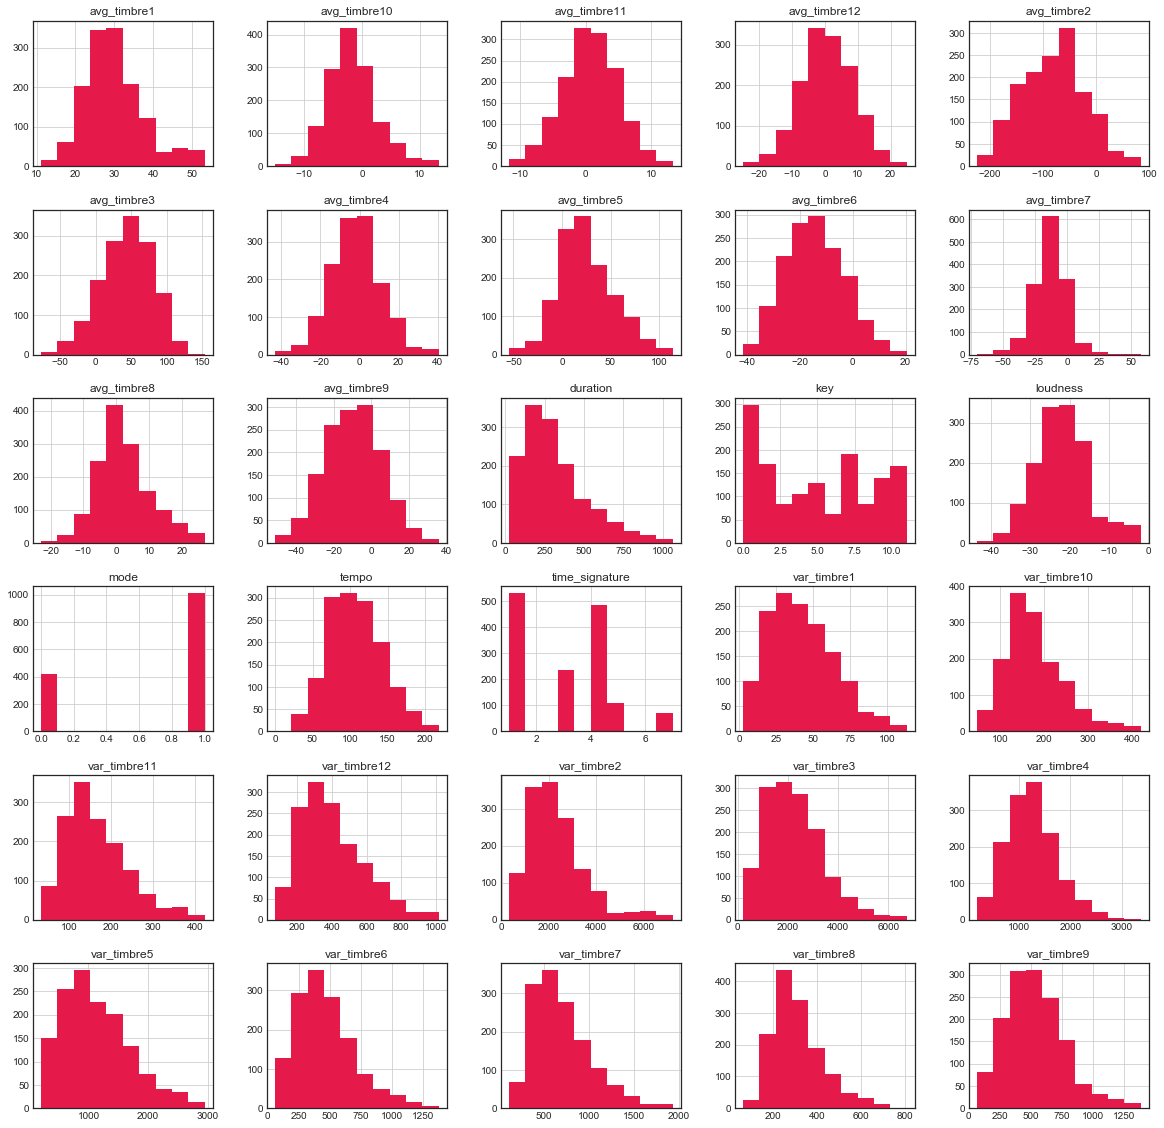

In [239]:
df_without_out.hist()
plt.show()

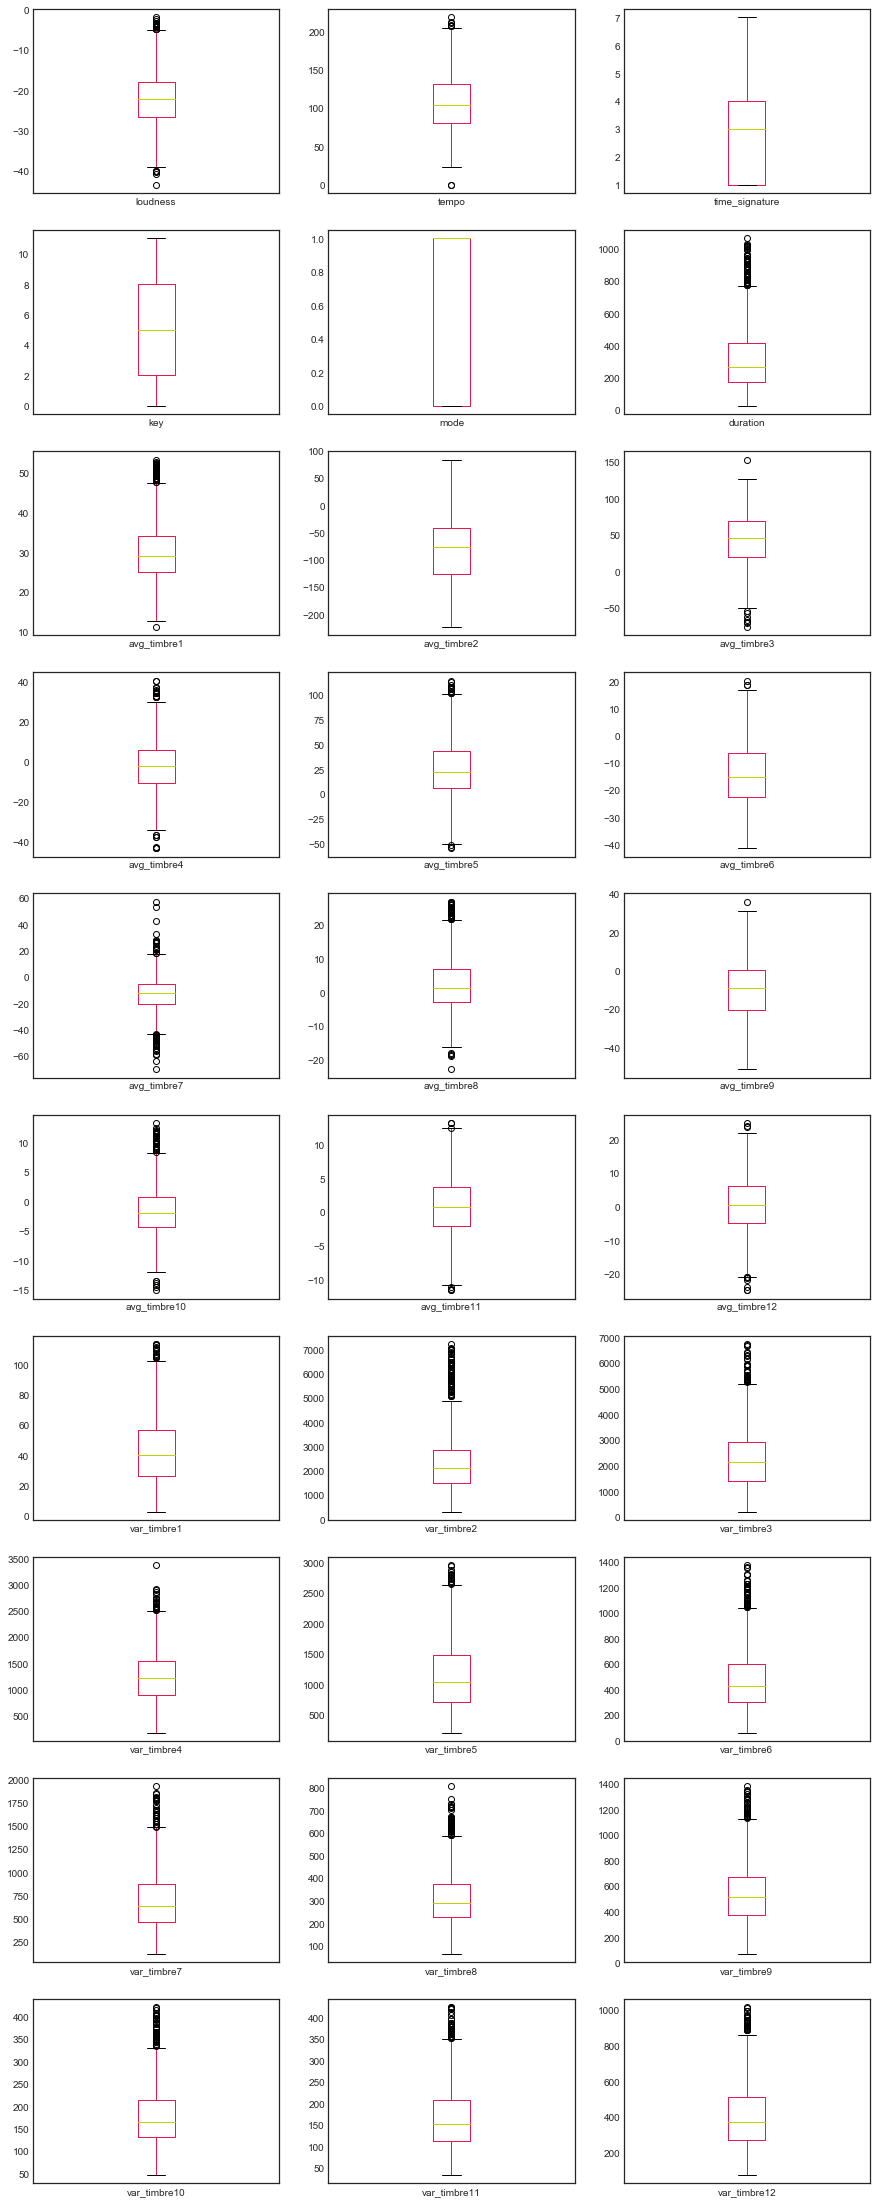

In [240]:
df_without_out.plot(kind='box', subplots=True, layout=(10,3), sharex=False, sharey=False, figsize=(15, 40))
plt.show()

### All together

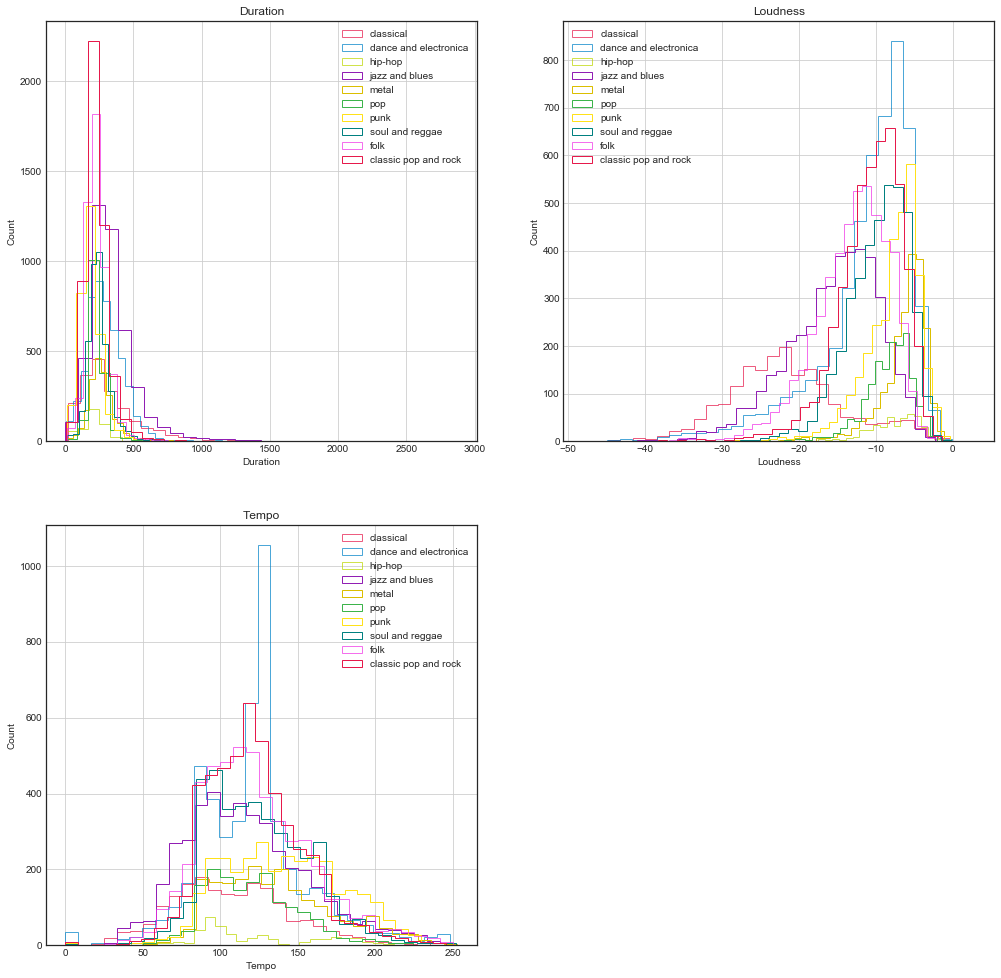

In [220]:
fig2 = plt.figure(figsize=(17, 17))

#Duration 
ax1 = fig2.add_subplot(221)
ax1.set_xlabel('Duration')
ax1.set_ylabel('Count')
ax1.set_title('Duration')
classical['duration'].hist(alpha=0.7, bins = 30, label='classical',histtype='step')
dance['duration'].hist(alpha=0.7, bins = 30, label='dance and electronica',histtype='step')
hiphop['duration'].hist(alpha=0.7, bins = 30, label='hip-hop',histtype='step')
jazz['duration'].hist(alpha=1, bins = 30, label='jazz and blues',histtype='step')
metal['duration'].hist(alpha=1, bins = 30, label='metal',histtype='step')
pop['duration'].hist(alpha=1, bins = 30, label='pop',histtype='step')
punk['duration'].hist(alpha=1, bins = 30, label='punk',histtype='step')
reggae['duration'].hist(alpha=1, bins = 30, label='soul and reggae',histtype='step')
folk['duration'].hist(alpha=0.7, bins = 30, label='folk',histtype='step')
poprock['duration'].hist(alpha=1, bins = 30, label='classic pop and rock',histtype='step')
plt.legend(loc = "upper right")

#Loudness
ax2 = fig2.add_subplot(222)
ax2.set_xlabel('Loudness')
ax2.set_ylabel('Count')
ax2.set_title('Loudness')
classical['loudness'].hist(alpha=0.7, bins = 30, label='classical',histtype='step')
dance['loudness'].hist(alpha=0.7, bins = 30, label='dance and electronica',histtype='step')
hiphop['loudness'].hist(alpha=0.7, bins = 30, label='hip-hop',histtype='step')
jazz['loudness'].hist(alpha=1, bins = 30, label='jazz and blues',histtype='step')
metal['loudness'].hist(alpha=1, bins = 30, label='metal',histtype='step')
pop['loudness'].hist(alpha=1, bins = 30, label='pop',histtype='step')
punk['loudness'].hist(alpha=1, bins = 30, label='punk',histtype='step')
reggae['loudness'].hist(alpha=1, bins = 30, label='soul and reggae',histtype='step')
folk['loudness'].hist(alpha=0.7, bins = 30, label='folk',histtype='step')
poprock['loudness'].hist(alpha=1, bins = 30, label='classic pop and rock',histtype='step')
plt.legend(loc = "upper left")

#Tempo
ax3 = fig2.add_subplot(223)
ax3.set_xlabel('Tempo')
ax3.set_ylabel('Count')
ax3.set_title('Tempo')
classical['tempo'].hist(alpha=0.7, bins = 30, label='classical',histtype='step')
dance['tempo'].hist(alpha=0.7, bins = 30, label='dance and electronica',histtype='step')
hiphop['tempo'].hist(alpha=0.7, bins = 30, label='hip-hop',histtype='step')
jazz['tempo'].hist(alpha=1, bins = 30, label='jazz and blues',histtype='step')
metal['tempo'].hist(alpha=1, bins = 30, label='metal',histtype='step')
pop['tempo'].hist(alpha=1, bins = 30, label='pop',histtype='step')
punk['tempo'].hist(alpha=1, bins = 30, label='punk',histtype='step')
reggae['tempo'].hist(alpha=1, bins = 30, label='soul and reggae',histtype='step')
folk['tempo'].hist(alpha=0.7, bins = 30, label='folk',histtype='step')
poprock['tempo'].hist(alpha=1, bins = 30, label='classic pop and rock',histtype='step')
plt.legend(loc = "upper right")



### Training 
- split dataset
- trian tree
- show tree
- evaluate 

In [242]:
df = sklearn.utils.shuffle(df)

test_df = df[:int(len(df)*0.2)]
train_df = df[int(len(df)*0.2):]

print(len(train_df))
print(len(test_df))

18011
4502


In [243]:
c = DecisionTreeClassifier(min_samples_split=100)

In [244]:
features = ['loudness', 'tempo', 'time_signature', 'key', 'mode', 'duration', 'avg_timbre1',
           'avg_timbre1','avg_timbre2','avg_timbre3','avg_timbre4','avg_timbre5','avg_timbre6',
           'avg_timbre9','avg_timbre8','avg_timbre9','avg_timbre10','avg_timbre11','avg_timbre12',
           'var_timbre1','var_timbre2','var_timbre3','var_timbre4','var_timbre5','var_timbre6',
           'var_timbre7','var_timbre8','var_timbre9','var_timbre10','var_timbre11','var_timbre12',]

In [245]:
x_train = train_df[features]
y_train = train_df['genre']

x_test = test_df[features]
y_test = test_df['genre']

dt = c.fit(x_train,y_train)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.948366 to fit



c:\users\jakub\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
c:\users\jakub\appdata\local\programs\python\python36\lib\site-packages\PIL\Image.py:2509: DecompressionBombWarning: Image size (136077198 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


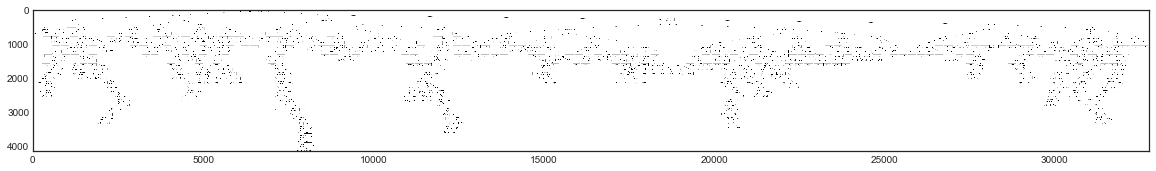

In [246]:
def printTree(tree, features, path):
    f = io.StringIO()
    export_graphviz(tree, out_file=f, feature_names=features)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img = misc.imread(path)
    plt.rcParams['figure.figsize'] = (20,20)
    plt.imshow(img)

printTree(dt, features, 'tree01.png')

In [247]:
y_pred = c.predict(x_test)
score = accuracy_score(y_test, y_pred)*100

print(score)
print(f1_score(y_test, y_pred, average=None)*100)



52.86539315859618
[66.31989597 53.20481928  9.6        55.16840883 60.67961165 36.97749196
 52.58899676 49.2949111 ]
